# Algorithmic Methods of Data Mining

## Homework 3
### Andrea Aiello, Daniele Mocavini, Mani Niharika Rachuri

In [1]:
from bs4 import BeautifulSoup
from collections import defaultdict
from collections import Counter
from collections import deque
import copy
from cmath import log
from heapq import nlargest
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from operator import itemgetter
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy
from numpy import linalg as LA
import re
import requests
import statistics
import string
from sklearn.cluster import KMeans
import json
import time
from wordcloud import WordCloud




## Data Collection

In [2]:
# First identify and save the folder where we have stored all the html files

mypath = "C:/Users/danie/OneDrive/Università/Data Science/Algorithmics (Aris-Yoannis)/Homeworks/Homework 3/aris database/lyrics_collection/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [3]:
# Now we can parse the pages and take for each all the information we need, like artist, title, url and the song 

complete_dictionary=defaultdict(list)
stringa="https://www.azlyrics.com/"
for i in onlyfiles:
    file = open("C:/Users/danie/OneDrive/Università/Data Science/Algorithmics (Aris-Yoannis)/Homeworks/Homework 3/aris database/lyrics_collection/"+ i, "r",encoding="utf8")
    soup = BeautifulSoup(file, 'lxml')
    
    artist = soup.findAll("span",{ "class" : "item-header-color" })
    
    title = soup.findAll("h1")
    lyric = soup.findAll("div", { "class" : "dn" })
    
    try:
        l = str(lyric[0]).replace('<br/>', ' ')
        l=l.replace("\", '')
        l=l.replace("\'", '')
        testo = str(l[31:-6])
        t = str(title[0])
        T = t[4:-12]
        a = str(artist[2])
        A = a[32:-14]
        url=stringa+"lyrics/"+A.replace(" ","").lower()+"/"+T.replace(" ","").lower()+".html"
        
        complete_dictionary[A,T].append([url, A, T, testo])
        
            
    except:
        pass


In [4]:
# In order to remove the internet problem, we have also make  a local copy of the dictionary created;
# we choce to use numpy for his speed

numpy.save("dizionario completo", complete_dictionary)

In [3]:
# If needed we can load the file with this command

complete_dictionary=dict(numpy.load("dizionario completo.npy").item())

In [15]:
# Create dict_of_songs, this will contein a list of dictionaries 

dict_of_songs = []
for [x,y] in complete_dictionary.keys():
    
    a = complete_dictionary[x,y]
    x=[]
    x.append(a[0][0]) #url
    x.append(a[0][1]) #artist
    x.append(a[0][2]) #song name
    x.append(a[0][3]) #lyrics
    tempdict = {"url": x[0],
                "artist": x[1],
                "song-name": x[2],
                "lyrics": x[3]
            }
    dict_of_songs.append(tempdict)

In [18]:
# Store the parsed songs as documents in MongoDB database, one document per song,
# using MongoDB Hosting: Database-as-a-Service by mLab
# To reduce the problems of the internet and speed up site response time, we decided to upload the files to several groups
# It's necessary use time sleep of 3 second for a correct count on mlab and for skip " quota excedeed" problem

# We use 158.31 MB of mlab's space

params = {'apiKey': 'jJFk7bsNFjagIf9nvxRQzq4AhVot1kkK'}
dbname = 'prova'
collection = 'Algorithmic_Methods_of_Data_Mining_Hw3'

In [ ]:
for i in range(0,len(dict_of_songs),10000):
    url = 'https://api.mlab.com/api/1/databases/' + dbname + '/collections/' + collection
    headers = {'content-type': 'application/json'}
    data = json.dumps(dict_of_songs[i:i+10000])
    response = requests.post(url, data=data, params=params, headers=headers)
    time.sleep(3)

In [31]:
# Get back documents
# l=<limit> - specify the limit for the number of results (default is 1000)

l='l=900000'
url = 'https://api.mlab.com/api/1/databases/' + dbname + '/collections/' + collection +'?'+ l +'&apiKey=jJFk7bsNFjagIf9nvxRQzq4AhVot1kkK&q'
query= url
response=requests.get(query)
data=(response.text)
dataset = json.loads(data)

In [9]:
# Create a list with the Artist Name

artists_name=[]
for aa in dataset:
    artists_name.append(aa["artist"])

In [7]:
# Create a list of list with song

song_list=[]
for ab in dataset:
    so=[]
    so.append(ab["lyrics"])
    song_list.append(so)

In [8]:
# Create a list with the songs-name

song_name=[]
for ac in dataset:
    song_name.append(ac["song-name"])

# Song Statistics

## Identify Artist with most songs and create a histogram of the number of songs per Artist


In [36]:
# Find the number of songs for each artist

provaa=(Counter(artists_name))
prova=dict(Counter(artists_name))
listaditupl=[(v, k) for v, k in prova.items()]


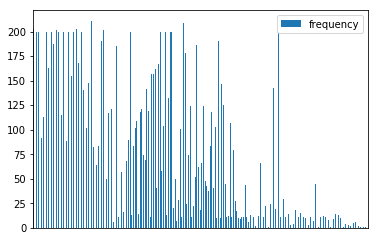

In [37]:
# Print the histogram of the number of songs for artist

df = pd.DataFrame(listaditupl, columns=['Artist Name', 'frequency'])
frame1=df.plot(kind='bar', x='Artist Name')
frame1.axes.get_xaxis().set_visible(False)
plt.show()

In [38]:
# Find the mean

media=statistics.mean([x[1] for x in listaditupl])

In [39]:
# Find the median

mediana=statistics.median([x[1] for x in listaditupl])

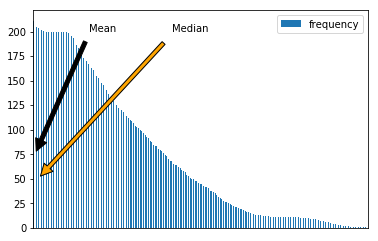

In [42]:
# We can also create an histogram ordered by number of songs written

ordered_list=provaa.most_common()
df = pd.DataFrame(ordered_list, columns=['Artist Name', 'frequency'])
frame1=df.plot(kind='bar', x='Artist Name')
frame1.axes.get_xaxis().set_visible(False)

plt.annotate('Mean', xy=(0,media), xytext=(200, 200),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('Median', xy=(0,mediana), xytext=(500, 200),
            arrowprops=dict(facecolor='orange', shrink=0.05),
            )
plt.show()

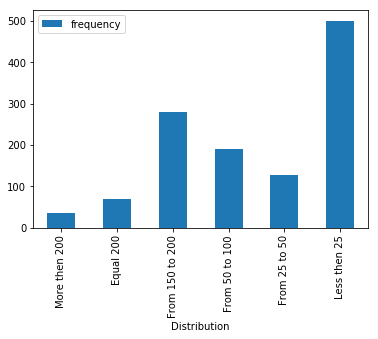

In [43]:
# Divide the list into this group and print the new plot

more_200 = ("More then 200",sum(Counter([t[1] for t in ordered_list if t[1] > 200]).values()))
equal200=("Equal 200",sum(Counter([t[1] for t in ordered_list if t[1] == 200]).values()))
a_150_to_200 = ("From 150 to 200",sum(Counter([t[1] for t in ordered_list if t[1] >= 100 and t[1] < 200 ]).values()))
a_50_to_100 = ("From 50 to 100",sum(Counter([t[1] for t in ordered_list if t[1] >= 50 and t[1] < 100 ]).values()))
a_25_to_50 = ("From 25 to 50",sum(Counter([t[1] for t in ordered_list if t[1] >= 25 and t[1] < 50 ]).values()))
less_20 = ("Less then 25",sum(Counter([t[1] for t in ordered_list if t[1]  < 25]).values()))
distribution=[more_200,equal200,a_150_to_200,a_50_to_100,a_25_to_50,less_20]
df = pd.DataFrame(distribution, columns=['Distribution', 'frequency'])
frame1=df.plot(kind='bar', x='Distribution')
plt.show()

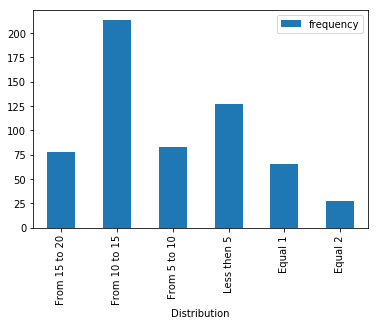

In [44]:
# Inside Less then 25 group we have the following situation

a_15_to_25 = ("From 15 to 20",sum(Counter([t[1] for t in ordered_list if t[1] >= 15 and t[1] < 25]).values()))
a_10_to_15 = ("From 10 to 15",sum(Counter([t[1] for t in ordered_list if t[1] >= 10 and t[1] < 15]).values()))
a_5_to_10 = ("From 5 to 10",sum(Counter([t[1] for t in ordered_list if t[1] >= 5 and t[1] < 10]).values()))
less_5 = ("Less then 5",sum(Counter([t[1] for t in ordered_list if t[1]  < 5]).values()))
equal2=("Equal 2",sum(Counter([t[1] for t in ordered_list if t[1] == 2]).values()))
equal1=("Equal 1",sum(Counter([t[1] for t in ordered_list if t[1] == 1]).values()))
distribution=[a_15_to_25,a_10_to_15,a_5_to_10,less_5,equal1,equal2]
df = pd.DataFrame(distribution, columns=['Distribution', 'frequency'])
frame1=df.plot(kind='bar', x='Distribution')
plt.show()

In [45]:
# Find who wrote more songs

print(ordered_list[0])

('David Bowie', 211)


In [46]:
# we can also find the top 10 artist who have written more songs

print(ordered_list[0:10])

[('David Bowie', 211), ('Lil Wayne', 211), ('Eminem', 210), ('Various Artists', 209), ('Dolly Parton', 209), ('Frank Sinatra', 209), ('Elton John', 208), ('Chris Brown', 207), ('Snoop Dogg', 206), ('Rolling Stones', 206)]


In [47]:
# And also the first 25

print(ordered_list[0:25])

[('David Bowie', 211), ('Lil Wayne', 211), ('Eminem', 210), ('Various Artists', 209), ('Dolly Parton', 209), ('Frank Sinatra', 209), ('Elton John', 208), ('Chris Brown', 207), ('Snoop Dogg', 206), ('Rolling Stones', 206), ('Paul McCartney', 205), ('Wiz Khalifa', 205), ('Bob Dylan', 205), ('Bee Gees', 205), ('Elvis Presley', 205), ('Kanye West', 204), ('John Denver', 204), ('Celine Dion', 204), ('Mariah Carey', 204), ('Billie Holiday', 203), ('Bruce Springsteen', 203), ('Eric Clapton', 203), ('Neil Young', 203), ('Nat King Cole', 203), ('U2', 203)]


Looking at the data we can first see the difference between mean (about 72) and median (45) so we can suppose to have some anomalous values.
We have in fact that 501 Artist wrote less then 25 songs (of which 65 wrote just 1 song) ed just 37 wrote more then 200 songs, without these excesses we have that 191 artist wrote from 150 to 200 songs (262 artist if we include also the number 200 songs).

In the top 10 most productive artist (excluding "Various Artist") we have just 1 band (Rolling Stones) and also looking at the first 25 we found just 2 other bad (U2 and Bee Gees), perhaps band's members have more frequently opposing views on songs and for this reason they write less or they melt.

Interestingly also note how in the top 10 most productive artist (excluding "Various Artist") we have even 5 rapper.

In the top 10 we also have 3 deceased artists (David Bowie, Frank Sinatra and Elvis Presley), searching for each the years active we have

- Elvis Presley: 24 years
- Bee Gees: 47 years
- Bob Dylan: 58 years
- Wiz Khalifa: 13 years
- Paul McCartney: 60 years
- Rolling stone: 55 years
- Snoop Dogg: 25 years
- Chris Brown: 12 years
- Elton John: 53 years
- Frank Sinatra: 63 years
- Dolly Parton: 58 years
- Eminem: 25 years
- David Bowie: 54 years
- Lil Wayne: 20 years



So the new ranking based on the number of songs written and years of activity is

- Chris Brown: 17.25
- Wiz Khalifa: 15.76
- Lil Wayne: 10.55
- Elvis Presley: 8:54
- Eminem: 8.40
- Snoop Dogg: 8.24

- Bee Gees: 4.36
- Elton John: 3.92
- David Bowie: 3.90
- Rolling stone: 3.74
- Dolly Parton: 3.60
- Bob Dylan: 3.53
- Paul McCartney: 3.41
- Frank Sinatra: 3.13

And again we can observe how rappers write many more songs than authors of other types of music 


## Identify the 20 most popular words (exclude stopwords) and comment

In [5]:
# Create a new list with songs without the most common stopwords of 17 different lenguage
# we have also edited the "english" file adding the the following words:
# "dont", "cant", "youre", "aint"
# we have also decided to add the condition len(word) >=2 to delete other non-included stopwords

stp1=stopwords.words('arabic')
stp2=stopwords.words('danish')
stp3=stopwords.words('dutch')
stp4=stopwords.words('english')
stp5=stopwords.words('finnish')
stp6=stopwords.words('french')
stp7=stopwords.words('german')
stp8=stopwords.words('hungarian')
stp9=stopwords.words('italian')
stp10=stopwords.words('kazakh')
stp11=stopwords.words('norwegian')
stp12=stopwords.words('portuguese')
stp13=stopwords.words('romanian')
stp14=stopwords.words('russian')
stp15=stopwords.words('spanish')
stp16=stopwords.words('swedish')
stp17=stopwords.words('turkish')
other_words=["dont", "cant", "youre", "aint"]
stp4=stp4+other_words

In [10]:
vuota=[]
for i in song_list:
    for line in i:
        prima=[]
        text=' '.join([word for word in line.lower().translate(str.maketrans('', '', string.punctuation)).split()
                      if len(word) >=2 and word not in stp1
                      and word not in stp2
                       and word not in stp3
                       and word not in stp4
                       and word not in stp5
                       and word not in stp6
                       and word not in stp7
                       and word not in stp8
                       and word not in stp9
                       and word not in stp10
                       and word not in stp11
                       and word not in stp12
                       and word not in stp13
                       and word not in stp14
                       and word not in stp15
                       and word not in stp16
                       and word not in stp17])
        prima.append(text)
        vuota.append(prima)

In [82]:
# Found the most common words

dicty = {}
for k in vuota:
    for sentence in k:
        for word in re.split('\s', sentence): # split with whitespace
            try:
                dicty[word] += 1
            except KeyError:
                dicty[word] = 1

In [83]:
# Order the dictionaries

ordered=sorted(dicty.items(), key=lambda x: x[1], reverse=True)

In [84]:
# Print the 20 most common words

print(ordered[0:20])

[('love', 131338), ('know', 108479), ('like', 100784), ('oh', 87311), ('got', 80794), ('get', 72267), ('go', 65788), ('one', 63850), ('time', 62619), ('baby', 61540), ('see', 60720), ('never', 57538), ('yeah', 52896), ('say', 50411), ('way', 48444), ('let', 47013), ('cause', 46033), ('make', 45460), ('back', 44800), ('take', 44798)]


We found that the most used word is "love", probably this primacy is attributable to the songs written in the 80's, considered by many the "decades of love", but it is also due to pop songs that often make use of it.
The 80s, with their protests, can probably also be found in the word "never" (in twelfth position).
The influence of the songs of the 70's may, however, be found in the word "baby" (in tithe position), which in those years begins to become a loving nickname, while we can assume that word "like" (in third position) is attributable almost entirely to our days, probably because of "like on Facebook".

## Identify the 10 most common singer names (e.g, “Alice,” “Bob,” “Frank”) and see whether singers whose name is the same tend to publish more songs than others


In [62]:
# remove the duplicate
non=Counter(artists_name)
nuovaprova=list(non.keys())

In [63]:
# Create a nested list with name and suppose that the name of the artist is always the first word 

wo=[]
for i in nuovaprova:
    words = re.findall(r'\w+', i)
    wo.append(words)
lst = [item[0] for item in wo]

In [64]:
# Find the 10 most common name

lst2=Counter(lst).most_common(10)
print(lst2)

[('The', 26), ('X', 13), ('Tom', 6), ('Queen', 6), ('Steve', 5), ('Q', 5), ('David', 5), ('Peter', 4), ('John', 4), ('Will', 4)]


In [65]:
# We have also "The", "X", "Queen" and "Q" in the most common name, so we have decided to delete this "false name"

lst2=Counter(lst).most_common(14)
use=[x[0] for x in lst2]
use.remove('The')
use.remove("X")
use.remove("Q")
use.remove("Queen")
print(use)

['Tom', 'Steve', 'David', 'Peter', 'John', 'Will', 'Johnny', 'James', 'George', 'Jimmy']


In [66]:
# Remember the top 25 productive artist and find their name

aba=ordered_list[0:25]
woo=[]
for i in [x[0] for x in aba]:
    words = (re.findall(r'\w+', i))
    woo.append(words)

test=[x[1] for x in aba]

a=[x for x in zip(woo, test)]

In [67]:
# Concatenate and find if there are some of the top Common Name in the top 25 most productive artists

for i in use:
    print((i,[item for item in a if item[0][0] == i]))

('Tom', [])
('Steve', [])
('David', [(['David', 'Bowie'], 211)])
('Peter', [])
('John', [(['John', 'Denver'], 204)])
('Will', [])
('Johnny', [])
('James', [])
('George', [])
('Jimmy', [])


We found that 2 of the most common name ("David", "John") is in the top 25 of the most productive artist:

- David Bowie: 211
- John Denver: 204

## Create a histogram of song lengths 

In [ ]:
# Create a list with the songs

song=[]
for ab in dataset:
    song.append(ab["lyrics"])

In [68]:
# Count number of words in each songs

num_words = [len(sentence.split()) for sentence in [value for value in song]]

In [69]:
# Concatenate
unitaa=[x for x in zip(song_name, num_words)]

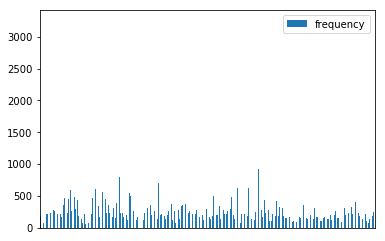

In [70]:
# Print the histogram

df = pd.DataFrame(unitaa, columns=['Artist Name', 'frequency'])
frame1=df.plot(kind='bar', x='Artist Name')
frame1.axes.get_xaxis().set_visible(False)
plt.show()

In [71]:
# order the list by song's length

ordered_unitaa=sorted(unitaa,key=lambda x: x[1], reverse=True)

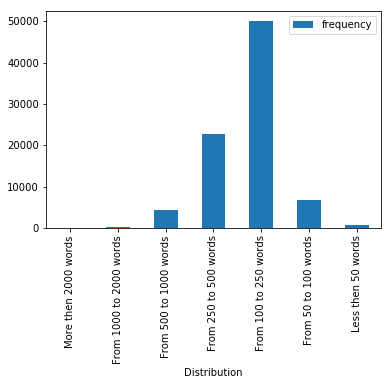

We found this values [('More then 2000 words', 11), ('From 1000 to 2000 words', 175), ('From 500 to 1000 words', 4388), ('From 250 to 500 words', 22821), ('From 100 to 250 words', 50094), ('From 50 to 100 words', 6789), ('Less then 50 words', 628)]


In [72]:
# Divide the list into this group and print the new plot

more_2000 = ("More then 2000 words",sum(Counter([t[1] for t in ordered_unitaa if t[1] > 2000]).values()))
a_1000_to_2000 = ("From 1000 to 2000 words",sum(Counter([t[1] for t in ordered_unitaa if t[1] >= 1000 and t[1] < 2000 ]).values()))
a_500_to_1000 = ("From 500 to 1000 words",sum(Counter([t[1] for t in ordered_unitaa if t[1] >= 500 and t[1] < 1000 ]).values()))
a_250_to_500 = ("From 250 to 500 words",sum(Counter([t[1] for t in ordered_unitaa if t[1] >= 250 and t[1] < 500 ]).values()))
a_100_to_250 = ("From 100 to 250 words",sum(Counter([t[1] for t in ordered_unitaa if t[1] >= 100 and t[1] < 250 ]).values()))
a_50_to_100 = ("From 50 to 100 words",sum(Counter([t[1] for t in ordered_unitaa if t[1] >= 50 and t[1] < 100 ]).values()))
less_50 = ("Less then 50 words",sum(Counter([t[1] for t in ordered_list if t[1]  < 50]).values()))
distribution=[more_2000,a_1000_to_2000,a_500_to_1000,a_250_to_500,a_100_to_250,a_50_to_100,less_50]
df = pd.DataFrame(distribution, columns=['Distribution', 'frequency'])
frame1=df.plot(kind='bar', x='Distribution')
plt.show()
print("We found this values %s" %distribution)

# Search Engine

## Index Program

In [4]:
# Create a list of list of id value

prova=[]
for i in dataset:
    prima=[]
    for k in (i['_id'].values()):
        prima.append(k)
    prova.append(prima)

In [ ]:
# We already have text without stopwords and punctuation
# list name = vuota

In [11]:
# Find stem

st = LancasterStemmer()
vuotaa=[]
for i in vuota:
    documents = [[st.stem(word) for word in sentence.split(" ")] for sentence in i]
    vuotaa.append(documents)

In [12]:
# Create new dictionaries with id, stemmed list of song and make a list of dictionary with also the frequency

dizionario=[]
for i,j in zip(prova,vuotaa):
    riprova=dict(zip(i,j))
    dizionario.append(riprova)

In [13]:
frequenze=[]
for i in vuotaa:
    for j in i:
        common=Counter(j)
        frequenze.append(common)

In [14]:
ook=[]
for i in frequenze:
    ok=[]
    a=dict(i)
    ok.append(a)
    ook.append(ok)

In [15]:
dizionario=[]
for i,j in zip(prova,ook):
    riprova=dict(zip(i,j))
    dizionario.append(riprova)

In [16]:
# In order to remove the internet problem, we have also make  a local copy of the dictionary created;
# we choce to use numpy for his speed

numpy.save("dizionario", dizionario)

In [ ]:
# If needed we can load the file with this command

dizionario=list(numpy.load("dizionario.npy"))

In [ ]:
#Find all the words used

parole=[]
for i in dizionario:
    for j in i.values():
        for k in j:
            parole.append(k)

In [ ]:
# Delete duplicate words

parole = list(set(parole))

In [ ]:
# Create the vocabulary

vocabulary=dict(zip(parole,parole))

In [ ]:
# Build the inverted index

caricare=[]
for words in vocabulary.values():
    for i in dizionario:
        for j in i.values():
            
            if words in j:
                nuovo_dizionario={}
                nuovo_dizionario[words]=((*i.keys(),j[words]))
                caricare.append(dict(nuovo_dizionario))

In [ ]:
index = {}
for d in caricare:
    for k,v in d.items():
        index.setdefault(k, []).append(v)
index=[{k:v} for k,v in index.items()]

In [ ]:
# In order to remove the internet problem, we have also make  a local copy of the dictionary created;
# we choce to use numpy for his speed

numpy.save("index", index)

In [ ]:
# If needed we can load the file with this command

index=list(numpy.load("index.npy")

In [ ]:
# Store Vocabulary and Index as documents in MongoDB database,
# using MongoDB Hosting: Database-as-a-Service by mLab
# To reduce the problems of the internet and speed up site response time, we decided to upload the files to several groups
# It's necessary use time sleep of 3 second for a correct count on mlab and for skip " quota excedeed" problem

# For this upload we needed 376.46 MB of free space on mlab, so we have used other account

params = {'apiKey': 'LQ6h51NkbYPZMkll06pUmSxguV4wvX0c'}
dbname = 'prova'
collection = 'Index'

In [ ]:
url = 'https://api.mlab.com/api/1/databases/' + dbname + '/collections/' + collection
headers = {'content-type': 'application/json'}
data = json.dumps(vocabulary)
response = requests.post(url, data=data, params=params, headers=headers)

In [ ]:
for i in range(0,len(index),10000):
    url = 'https://api.mlab.com/api/1/databases/' + dbname + '/collections/' + collection
    headers = {'content-type': 'application/json'}
    data = json.dumps(index[i:i+10000])
    response = requests.post(url, data=data, params=params, headers=headers)
    time.sleep(3)

## Search Program

In [ ]:
# Create a list of id value

lista_id=[]
for i in dataset:
    lista_id.append(*i['_id'].values())

In [ ]:
# Create a list with the songs-name

song_name=[]
for ac in dataset:
    song_name.append(ac["song-name"])

In [ ]:
# Concatenate

song_id=[x for x in zip(lista_id, song_name)]

In [ ]:
# Create a new index with also tf and idf

lista_molti=[]
for word in index:
    for i in word.values():
        for yt in [x[1] for x in i]:
            lista_molti.append((yt,(log(len(dizionario)/(len([x[1] for x in i]))).real),yt*(log(len(dizionario)/(len([x[1] for x in i]))).real)))

prova=[]
cont=0
for word in index:
    provaa=[]
    for chiave in word:
        k=dict(word[chiave])
        
        for elem in k.keys():
            k[elem]=lista_molti[cont]
            cont+=1
        provaa.append(k)
    prova.append((provaa))
    
indexx=copy.deepcopy(index)

looper = 0
for dic in indexx:
    for key in dic.keys():
        dic[key] = prova[looper]
        looper += 1

In [ ]:
numpy.save('indexx',indexx)          

In [ ]:
indexx_idf={}
parole=[]
for i in indexx:
    for ii in i.values():
        for iii in ii:
            G = str(i.keys())[12:-3]
            indexx_idf[G]=([x[1] for x in iii.values()][0])

In [ ]:
def query_1():
    # find stem in queryy

    query=[st.stem(i) for i in queryy]

    # find docs with query and weight
    print('Be patient, we are searching for the documents')
    dq = deque()
    doc= deque()
    moltiplicare= deque()
    for i in index:
        for j in i:
            if any(query[o] == j for o in range(len(query))):
                dq.append(i)
                for n in i.values():
                    moltiplicare.append((log(len(dizionario)/(len(n)))).real)
                    doc.append([x[0] for x in n])
    

    docs=list(set([j for i in doc for j in i]))
    L=len(docs)
    print('Done... found %s documents'%len(docs))
    if L == 0:
        print('No documents')
        return

    # calculate cosine similarity 
    print('Be patient, we are calculating the cosine similarity')
    dict_v = {}
    listone=deque()
    for i in docs:
        vettori=deque()                              
        for j in range(len(dizionario)):
            G = str(dizionario[j].keys())[12:-3]
            if i == G:
                C = dizionario[j][G]
        q_v = dict.fromkeys(C, 0)        
        for q in query:
            for j in C:
                if j ==q:
                    q_v[j] += 1
                
            vettori.append(q_v)
        
        b1=deque()
        b2=deque()
        for k in C.keys():
            try:
                b2.append(indexx_idf[k])
            except:
                b2.append(0)
        for k in C.values():
            b1.append(k)
        b1=numpy.array(b1)
        b2=numpy.array(b2)
        b=b1*b2
        
        
        Query=deque()
        for l in vettori:
            a=deque()
            for h in l.values():
                a.append(h)
            a=numpy.array(a)
            Query.append(a)
        listone.append(Query)


        for x in listone:
            R=0
            for j in range(len(x)):
                try:
                    R+=x[j]*moltiplicare[j]
                except:
                    print('Invalid query: one or more words are not in the database')
                    return
                

        dict_v[i] = numpy.dot(R,b) / (LA.norm(R)*LA.norm(b))

        if L <100:
            if len(dict_v)%10==0:
                print("Done %s on %s " %(len(dict_v),L))
        else:
            if len(dict_v)%100==0:
                print("Done %s on %s " %(len(dict_v),L))


    # find top 10 docs
    top10_values = nlargest(10, dict_v.values())
    classifica=deque()
    for i in top10_values:
        for b in dict_v.values():
            if i == b:
                classifica.append(list(dict_v.keys())[list(dict_v.values()).index(b)])
    lista_finale=deque()
    for i in song_id:
        for m in classifica:
            if m == i[0]:
                lista_finale.append(i[1])
    print('These are the song name:',list(lista_finale))
    
    return
    

In [1]:
def query_2():
    # find stem in queryy
    query=[st.stem(i) for i in queryy]
    print('Be patient, we are searching for the documents')
    
    dq = []
    for i in index:
        for j in i:
            if any(query[o] == j for o in range(len(query))):
                dq.append(i)
    aa=[]
    for i in dq:
        for k in i.values():
            aa.append([x[0] for x in k])
    aa=[j for i in aa for j in i]
    
    # Find the documents that contein all the query term
    comuni=list(set([x for x in aa if aa.count(x) >= len(query)]))
    
    L=len(comuni)
    if L == 0:
        print('No documents')
        return
    
    print('Found %s documents , give a value' %len(comuni))
    k=int(input())
    
    # vvv will contain a dictionary for each doc that matches the query, with words and respective tf_idf normalized
    vvv = []
    # vocabolario will contain all the words of the union of all the documents taken only once
    vocabolario = set()

    for i in comuni:
        vettori=[]                              
        for j in range(len(dizionario)):
            G = str(dizionario[j].keys())[12:-3]
            if i == G:
                C = dizionario[j][G]
        Query=[]
        b1=[]
        b2=[]
        for kk in C.keys():
            vocabolario.add(kk)
            try:
                b2.append(indexx_idf[kk])
            except:
                b2.append(0)
        for kk in C.values():
            b1.append(kk)
        b1=numpy.array(b1)
        b2=numpy.array(b2)
        b=b1*b2

        f = {}
        KEY = []
        bb= [float(i)/numpy.linalg.norm(b) for i in b]
        for w in C.keys():
            KEY.append(w)
        for t in range(len(b)):
            f[KEY[t]] = bb[t]
        vvv.append(f) 
    Q = []                  
    for i in range(len(comuni)):
        #vector that will contain the values related to the words, with the order in which they appear in the dictionary
        V = []
        for j in vocabolario:
            if j not in vvv[i]: 
                V.append(0)
            if j in vvv[i]:
                V.append(vvv[i][j])
        Q.append(V)
    kmeans = KMeans(n_clusters = k, init = 'random')
    kmeans.fit(Q)
    pred = kmeans.predict(Q)
    
    #Associate the number of the cluster to each document
    dict_cluster = dict(zip(comuni,pred))
    
    # Regroup by n clusters
    inv_map = {}
    for l, v in dict_cluster.items():
        inv_map[v] = inv_map.get(v, [])
        inv_map[v].append(l)
    artist=[]
    for ok in inv_map.values():
        artisti=[]
        for j in ok:
            for i in range(len(dataset)):
                if dataset[i]['_id']['$oid'] == j:
                    artisti.append(dataset[i]['artist'])
        artist.append(artisti)
        
    song_name=[]
    for ok in inv_map.values():
        canzoni=[]
        for j in ok:
            for i in range(len(dataset)):
                if dataset[i]['_id']['$oid'] == j:
                    canzoni.append(dataset[i]['song-name'])
        song_name.append(canzoni)
        
    lyrics=[]
    for ok in inv_map.values():
        testi=[]
        for j in ok:
            for i in range(len(dataset)):
                if dataset[i]['_id']['$oid'] == j:
                    testi.append(dataset[i]['lyrics'])
        lyrics.append(testi)
    
    # Remove stopwords
    stp1=stopwords.words('arabic')
    stp2=stopwords.words('danish')
    stp3=stopwords.words('dutch')
    stp4=stopwords.words('english')
    stp5=stopwords.words('finnish')
    stp6=stopwords.words('french')
    stp7=stopwords.words('german')
    stp8=stopwords.words('hungarian')
    stp9=stopwords.words('italian')
    stp10=stopwords.words('kazakh')
    stp11=stopwords.words('norwegian')
    stp12=stopwords.words('portuguese')
    stp13=stopwords.words('romanian')
    stp14=stopwords.words('russian')
    stp15=stopwords.words('spanish')
    stp16=stopwords.words('swedish')
    stp17=stopwords.words('turkish')
    other_words=["dont", "cant", "youre", "aint"]
    stp4=stp4+other_words
    
    vuota=[]
    for i in lyrics:
        for line in i:
            prima=[]
            text=' '.join([word for word in line.lower().translate(str.maketrans('', '', string.punctuation)).split()
                          if len(word) >=2 and word not in stp1
                          and word not in stp2
                           and word not in stp3
                           and word not in stp4
                           and word not in stp5
                           and word not in stp6
                           and word not in stp7
                           and word not in stp8
                           and word not in stp9
                           and word not in stp10
                           and word not in stp11
                           and word not in stp12
                           and word not in stp13
                           and word not in stp14
                           and word not in stp15
                           and word not in stp16
                           and word not in stp17])
            prima.append(text)
        vuota.append(prima)
    
    prova=[]
    for kkk in vuota:
        canzone=[]
        for sentence in kkk:
            for word in re.split('\s', sentence): # split with whitespace
                canzone.append(word)
        prova.append(canzone)
        
    lyri=[]
    for i in prova:
        lst2=Counter(i).most_common(10)
        lyri.append([x[0] for x in lst2])
        
    aaa=artist+song_name+lyri
    cloud=[]
    for i in range(0,k):
        cloud.append(aaa[i]+aaa[i+k]+aaa[i+k+k])
    
    for i in cloud:
        str1=' '.join(i)
        wordcloud=WordCloud(background_color='green',
                        width=1200,
                        height=1000).generate(str1)
        plt.imshow(wordcloud)
        plt.axis('off')
        plt.show()
    
    return

In [ ]:
print('enter set of words')
queryy=(input().split())

# Stem query
query=[]
for i in queryy:
    documents = st.stem(i)
    query.append(documents)
    
print("Choose query 1 or 2")
n=int(input())
if n==1:
    start_time=time.time()
    query_1()
elif n==2:
    start_time=time.time()
    query_2()
else:
    print('Wrong digit')
    for i in (3,2,1):
        print('Computer will self-destruct %s seconds '%i)
        time.sleep(1)
    print('Boom')
    
print(' used %s second' %(time.time()-start_time))